# GA for clustring 
1. Initialization (Population Generation)
2. Fitness Evaluation (Objective Function)
3. Selection
4. Crossover (Recombination)
5. Mutation
6. Replacement
7. Termination


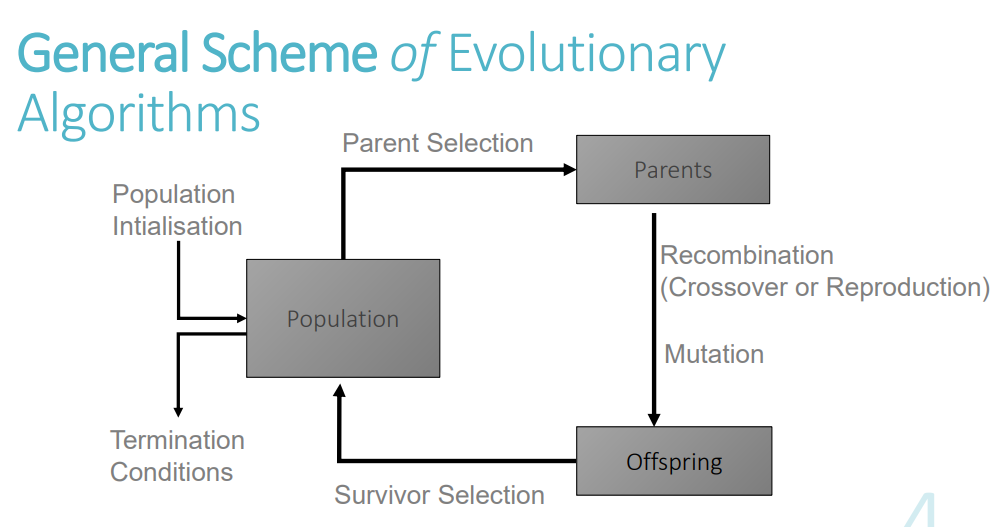

# Initialization
----
- A population of potential solutions is generated randomly
- Each individual in the population can be thought of as a chromosome in genetic algorithms, where the genes represent the coordinates of the K centroids.
- chromosome (genotype)
- representations 
  - Prototype-based Encoding ✅
    - Each chromosome represents coordinates of cluster centroids
  - Label-based Representation
    - Each gene corresponds to a data point, and its value is the cluster ID.
  - Locus-based Adjacency Graph (LAG)
    - Each gene indicates which other data point it connects to, forming clusters as connected components.
  - Binary Representation
    - Using a binary string to represent point-cluster assignments
--- 
## Prototype-based Encoding
- we can present this in two possible structures 
  - Flat List of K * d ✅
  - List of Tuples


In [44]:
DIM = 4 # dimensions
K = 3 # centroids and clusters number

In [46]:
import numpy as np
from typing import List, Tuple, Callable
from dataclasses import dataclass
import random

class GeneticKMeans:
    def __init__(self, 
                 n_clusters: int = K,
                 dim: int = DIM,
                 pop_size: int = 50,
                 mutation_rate: float = 0.1,
                 crossover_rate: float = 0.8):
        self.n_clusters = n_clusters
        self.dim = dim
        self.chromosome_length = n_clusters * dim
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = []
        
    def initialize_population(self, data: np.ndarray) -> None:
        """Initialize population with random centroids within data bounds"""
        min_bounds = np.min(data, axis=0)
        max_bounds = np.max(data, axis=0)
        
        self.population = []
        for _ in range(self.pop_size):
            chromosome = []
            for _ in range(self.n_clusters):
                centroid = [np.random.uniform(min_bounds[d], max_bounds[d]) 
                          for d in range(self.dim)]
                chromosome.extend(centroid)
            self.population.append(np.array(chromosome))
    
    def fitness_function(self, chromosome: np.ndarray, data: np.ndarray) -> float:
        """Calculate fitness using sum of squared distances"""
        centroids = self._decode_chromosome(chromosome)
        distances = self._calculate_distances(data, centroids)
        cluster_assignments = np.argmin(distances, axis=1)
        
        # Calculate within-cluster sum of squares
        wcss = 0
        for k in range(self.n_clusters):
            if sum(cluster_assignments == k) > 0:
                cluster_points = data[cluster_assignments == k]
                centroid = centroids[k]
                wcss += np.sum((cluster_points - centroid) ** 2)
        
        return 1 / (wcss + 1e-10)  # Higher fitness for lower WCSS
    
    def _decode_chromosome(self, chromosome: np.ndarray) -> np.ndarray:
        """Convert flat chromosome to centroids matrix"""
        return chromosome.reshape(self.n_clusters, self.dim)
    
    def _calculate_distances(self, data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        """Calculate distances between data points and centroids"""
        distances = np.zeros((len(data), self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.sum((data - centroids[k]) ** 2, axis=1)
        return distances
    
    def single_point_crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Perform single-point crossover"""
        if random.random() < self.crossover_rate:
            point = random.randint(1, self.chromosome_length - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        return parent1.copy(), parent2.copy()
    
    def uniform_mutation(self, chromosome: np.ndarray, data: np.ndarray) -> np.ndarray:
        """Perform uniform mutation"""
        mutated = chromosome.copy()
        min_bounds = np.min(data, axis=0)
        max_bounds = np.max(data, axis=0)
        
        for i in range(self.chromosome_length):
            if random.random() < self.mutation_rate:
                dim_idx = i % self.dim
                mutated[i] = np.random.uniform(min_bounds[dim_idx], max_bounds[dim_idx])
        
        return mutated
    
    def tournament_selection(self, population: List[np.ndarray], 
                           fitness_values: List[float], 
                           tournament_size: int = 3) -> np.ndarray:
        """Select parent using tournament selection"""
        tournament_idx = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_idx]
        winner_idx = tournament_idx[np.argmax(tournament_fitness)]
        return population[winner_idx].copy()
    
    def run_evolution(self, data: np.ndarray, n_generations: int = 50) -> Tuple[List[float], np.ndarray]:
        """Run the complete genetic algorithm evolution process"""
        best_fitness_history = []
        
        # Initialize population if not already initialized
        if not self.population:
            self.initialize_population(data)
        
        # Calculate initial fitness for each chromosome
        fitness_values = [self.fitness_function(chromosome, data) for chromosome in self.population]
        best_fitness = max(fitness_values)
        best_chromosome = self.population[fitness_values.index(best_fitness)]
        best_fitness_history.append(best_fitness)
        
        for generation in range(n_generations):
            new_population = []
            
            # Elitism: Keep the best chromosome
            elite_idx = fitness_values.index(max(fitness_values))
            new_population.append(self.population[elite_idx])
            
            # Generate new population
            while len(new_population) < self.pop_size:
                # Selection
                parent1 = self.tournament_selection(self.population, fitness_values)
                parent2 = self.tournament_selection(self.population, fitness_values)
                
                # Crossover
                child1, child2 = self.single_point_crossover(parent1, parent2)
                
                # Mutation
                child1 = self.uniform_mutation(child1, data)
                child2 = self.uniform_mutation(child2, data)
                
                new_population.append(child1)
                if len(new_population) < self.pop_size:
                    new_population.append(child2)
            
            # Update population
            self.population = new_population
            
            # Calculate fitness for new population
            fitness_values = [self.fitness_function(chromosome, data) for chromosome in self.population]
            
            # Update best solution
            generation_best_fitness = max(fitness_values)
            if generation_best_fitness > best_fitness:
                best_fitness = generation_best_fitness
                best_chromosome = self.population[fitness_values.index(best_fitness)]
            
            best_fitness_history.append(best_fitness)
            
            # Optional: Print progress
            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_fitness}")
        
        return best_fitness_history, best_chromosome

In [47]:
import pandas as pd
pro_data_mall = pd.read_csv('../Processed_datasets/mall_customer_segmentation/processed_data.csv')
pro_data_mall.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


Generation 0: Best fitness = 0.0023790084322952857
Generation 10: Best fitness = 0.00273562506555571
Generation 20: Best fitness = 0.002794701150205281
Generation 30: Best fitness = 0.002824909024057317
Generation 40: Best fitness = 0.002849672529924475
Generation 50: Best fitness = 0.0028507777611812323
Generation 60: Best fitness = 0.002867550890662532
Generation 70: Best fitness = 0.0028743675748443215
Generation 80: Best fitness = 0.0028755386918311522
Generation 90: Best fitness = 0.0028755386918311522
Generation 100: Best fitness = 0.002875589616764117
Generation 110: Best fitness = 0.002883367693242225
Generation 120: Best fitness = 0.002885038441163517
Generation 130: Best fitness = 0.002885038441163517
Generation 140: Best fitness = 0.002885065951315495
Best Chromosome: [ 0.9626948  -0.55196843 -0.40216161  0.39383212  0.12706304  0.98279809
 -1.18300574  0.54607652 -0.7783835  -0.04003516  0.84463741  0.4346721 ]
Best Fitness: 0.002885065951315495
Best Centroids: [[ 0.9626948

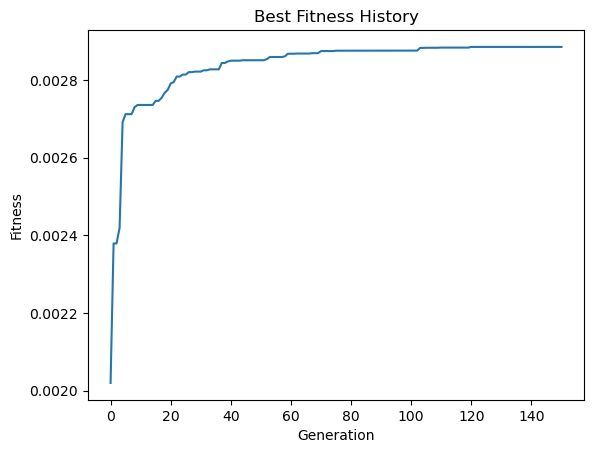

In [48]:
ga_kmeans = GeneticKMeans(n_clusters=K, dim=DIM, pop_size=50, mutation_rate=0.1, crossover_rate=0.8)
ga_kmeans.initialize_population(pro_data_mall.values)
best_fitness_history, best_chromosome = ga_kmeans.run_evolution(pro_data_mall.values, n_generations=150)
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", max(best_fitness_history))
print("Best Centroids:", ga_kmeans._decode_chromosome(best_chromosome))
import matplotlib.pyplot as plt
plt.plot(best_fitness_history)
plt.title('Best Fitness History')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()


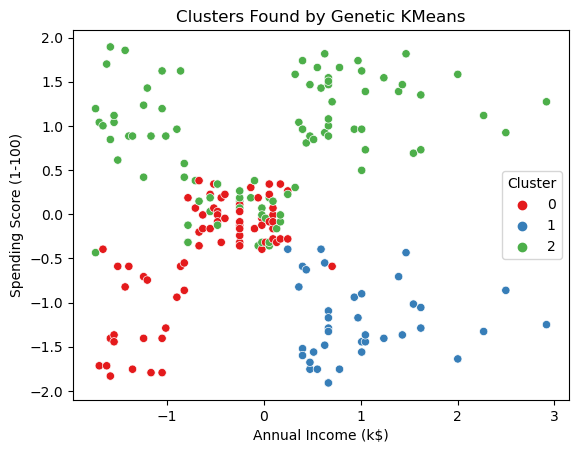

In [49]:
# cluster the data using the best centroids
best_centroids = ga_kmeans._decode_chromosome(best_chromosome)
cluster_assignments = np.argmin(ga_kmeans._calculate_distances(pro_data_mall.values, best_centroids), axis=1)
pro_data_mall['Cluster'] = cluster_assignments
pro_data_mall.head()
import seaborn as sns
sns.scatterplot(data=pro_data_mall, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='Set1')
plt.title('Clusters Found by Genetic KMeans')
plt.show()
